# Notebook for building and analyzing calibration curve data for nitrate by CE-UV/vis
- Uses raw data from `01-input_data` directory (`cal_curve.csv`, `lfb_data.csv`, `lod_data.csv`)
- Calculates calibration curve with and without ISTD correction for comparison
- Calculates error, LOD, LOQ, %recovery of blanks
- Plots calibration curve with error bars

## Calculating calibration curve from CE calibration data
- Uses peak areas from MassHunter output
- Converts our original ppm concentrations to mM for ease of reporting later on
- Determines LOD, LOQ, %Recovery of LFBs

In [1]:
import pandas as pd #For dataframes
import matplotlib.pyplot as plt #For pretty plots
import numpy as np #For extra math stuff
from scipy.stats import linregress, t #For linear regression for our cal curves and t-test for confidence intervals
from scipy.stats import levene #Levene test for heteroscedasticity
import statsmodels.api as sm #For OLS and WLS modeling in case of heteroscedasticity
import pickle #For pickling things to save for later

In [2]:
#Read our calibration curve data, LFB, and LOD data
cal_data=pd.read_csv("../01-input_data/cal_curve.csv")
lfb_data=pd.read_csv("../01-input_data/lfb_data.csv")
lod_data=pd.read_csv("../01-input_data/lod_data.csv")

In [3]:
cal_data.head(5)

,concentration,istd_area,no3_area
0,0.50,12.35,0.46
1,0.50,12.16,0.49
2,0.50,11.92,0.41
3,1.25,14.73,1.07
4,1.25,14.51,1.22


In [4]:
#Let's convert everything from ppm to mM of NO3-
mw_no3=62.004 #molecular weight of NO3- = 62.004g/mol, mM = ppm/MW
cal_data['mM']=cal_data['concentration']/mw_no3
lfb_data['mM']=lfb_data['concentration']/mw_no3
lod_data['mM']=lod_data['concentration']/mw_no3

In [5]:
#Calculate our response factors from NO3 and ISTD peak areas for all three datasets
cal_data['rf'] = cal_data['no3_area']/cal_data['istd_area']
lod_data['rf'] = lod_data['no3_area']/lod_data['istd_area']
lfb_data['rf'] = lfb_data['no3_area']/lfb_data['istd_area']

In [6]:
cal_data.head(5)

,concentration,istd_area,no3_area,mM,rf
0,0.50,12.35,0.46,0.008064,0.037247
1,0.50,12.16,0.49,0.008064,0.040296
2,0.50,11.92,0.41,0.008064,0.034396
3,1.25,14.73,1.07,0.020160,0.072641
4,1.25,14.51,1.22,0.020160,0.084080


In [7]:
lod_data.head(5)

,concentration,istd_area,no3_area,mM,rf
0,0.5,12.16,0.49,0.008064,0.040296
1,0.5,11.92,0.41,0.008064,0.034396
2,0.5,13.31,0.67,0.008064,0.050338
3,0.5,12.35,0.46,0.008064,0.037247
4,0.5,11.33,0.37,0.008064,0.032657


In [8]:
lfb_data.head(5)

,concentration,rep,istd_area,no3_area,analysis_day,mM,rf
0,1.290239,1,11.31,69.58,1,0.020809,6.152078
1,1.290239,2,10.81,66.89,1,0.020809,6.187789
2,1.290239,3,10.18,68.96,1,0.020809,6.774067
3,0.112896,1,12.71,7.64,1,0.001821,0.601101
4,0.112896,2,11.43,6.32,1,0.001821,0.552931


In [9]:
#Calculate our cal curve without ISTD correction first, using NO3- peak area
x=cal_data['mM']
y=cal_data['no3_area']
slope, intercept, r_value, p_value, std_err = linregress(x,y)

#Also need standard error of y-intercept, linregress does not calculate this for us so have to do it manually
y_pred=intercept+slope*x
residuals=y-y_pred
n=len(x)
s_y=np.sqrt(np.sum(residuals**2)/(n-2))
x_mean=np.mean(x)
Sxx=np.sum((x-x_mean)**2)
se_intercept=s_y*np.sqrt(1/n + x_mean**2/Sxx)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R^2: {r_value**2}")
print(f"Standard error of slope: {std_err}")
print(f"Standard error of y-intercept: {se_intercept}")

Slope: 55.322598762232175
Intercept: 0.3570474987097043
R^2: 0.9673681161305245
Standard error of slope: 2.032159337979013
Standard error of y-intercept: 2.5212126435078264


In [10]:
#Repeat but with response factors instead of NO3- peak area
x=cal_data['mM']
y=cal_data['rf']
slope, intercept, r_value, p_value, std_err = linregress(x,y)

#Error of y-int
y_pred=intercept+slope*x
residuals=y-y_pred
n=len(x)
s_y=np.sqrt(np.sum(residuals**2)/(n-2))
x_mean=np.mean(x)
Sxx=np.sum((x-x_mean)**2)
se_intercept=s_y*np.sqrt(1/n + x_mean**2/Sxx)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R^2: {r_value**2}")
print(f"Standard error of slope: {std_err}")
print(f"Standard error of y-intercept: {se_intercept}")

Slope: 4.35083324189003
Intercept: 0.021153689353422767
R^2: 0.997811010140888
Standard error of slope: 0.040756807918180794
Standard error of y-intercept: 0.05056521775232908


In [11]:
#Using ISTD correction improved R^2 which is a good sign
#R^2 of 0.9978 is acceptable, can continue

In [12]:
#Now need to calculate LOD and LOQ
#LOD = concentration of 3.3*stdev(low concentration standard measured many times)
#LOQ = concenetration of 10*stdev(low concentration standard measured many times)
lod = 3.3*lod_data['rf'].std()
loq = 10*lod_data['rf'].std()

lod_conc = (lod-intercept)/slope
loq_conc = (loq-intercept)/slope

print(f"LOD: {lod_conc}")
print(f"LOQ: {loq_conc}")

LOD: 0.007844482501767336
LOQ: 0.033642463558783225


In [13]:
#Our lowest calibration point is below the LOQ, so have to start over without including that point
mask = np.isclose(cal_data['mM'], 0.008, atol=1e-4)
cal_data = cal_data.drop(cal_data[mask].index)

In [14]:
cal_data.head(5)

,concentration,istd_area,no3_area,mM,rf
3,1.25,14.73,1.07,0.02016,0.072641
4,1.25,14.51,1.22,0.02016,0.084080
5,1.25,11.03,0.71,0.02016,0.064370
6,2.50,10.53,1.37,0.04032,0.130104
7,2.50,11.67,1.59,0.04032,0.136247


In [15]:
#Do all over again with new datapoints 
x=cal_data['mM']
y=cal_data['rf']
slope, intercept, r_value, p_value, std_err = linregress(x,y)

#Error of y-int
y_pred=intercept+slope*x
residuals=y-y_pred
n=len(x)
s_y=np.sqrt(np.sum(residuals**2)/(n-2))
x_mean=np.mean(x)
Sxx=np.sum((x-x_mean)**2)
se_intercept=s_y*np.sqrt(1/n + x_mean**2/Sxx)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R^2: {r_value**2}")
print(f"Standard error of slope: {std_err}")
print(f"Standard error of y-intercept: {se_intercept}")

Slope: 4.349145705699257
Intercept: 0.02485897917116242
R^2: 0.9976757952879014
Standard error of slope: 0.04475433290251585
Standard error of y-intercept: 0.05889277914321376


In [16]:
#Now need to calculate LOD and LOQ
#LOD = concentration of 3.3*stdev(low concentration standard measured many times)
#LOQ = concenetration of 10*stdev(low concentration standard measured many times)
lod = 3.3*lod_data['rf'].std()
loq = 10*lod_data['rf'].std()

lod_conc = (lod-intercept)/slope
loq_conc = (loq-intercept)/slope

print(f"LOD: {lod_conc}")
print(f"LOQ: {loq_conc}")

LOD: 0.006995568204694729
LOQ: 0.032803559279683925


In [17]:
#LOQ is now between our two lowest points on cal curve, which is acceptable

## Evaluate cal curve
- Check for heteroscedasticity to ensure an OLS model is a best fit as opposed to a WLS model
- UV-vis data often has increasing variance with signal strength, so WLS sometimes is a better fit, but if our data are homoscedastic then we don't have to worry about it
- Plots residuals to visually inspect and performs Levene test for heteroscedasticity

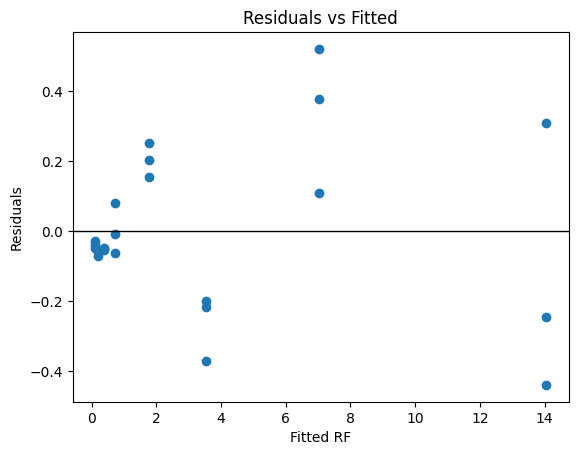

In [18]:
#Define our x and y variables
x = sm.add_constant(cal_data['mM'])
y = cal_data['rf']

#Build Ordinary Least Squares models
ols = sm.OLS(y,x).fit()

#Plot residuals to look for heteroscedasticity
plt.scatter(ols.fittedvalues,ols.resid)
plt.axhline(0,color='k',lw=1)
plt.xlabel("Fitted RF")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

In [19]:
#Appears fairly homoscedastic
#Let's do a Levene test to be sure
groups=[g['rf'].values for _, g in cal_data.groupby('mM')]
stat, p = levene(*groups, center='median')
print(f"Levene p-value: {p:.4f}")

Levene p-value: 0.1937


In [20]:
#Looks like our values are homoscedastic, no need to worry about a weighted least squares model

## Plot cal curve
- Plots cal curve with 95% prediction interval so we can see visually where our accuracy lies

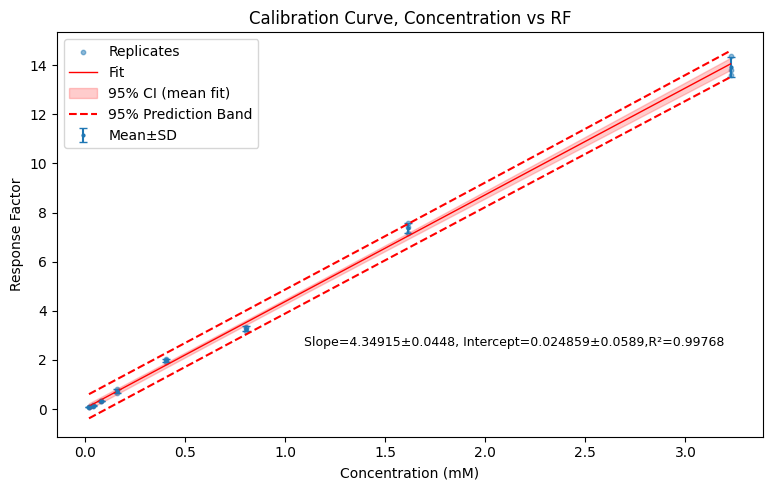

In [21]:
#Define our curve again just in case
x = cal_data['mM']
y = cal_data['rf']
slope, intercept, r, p, stderr = linregress(x,y)

#Find standard error of intercept again
n = len(x)
x_mean = np.mean(x)
Sxx = np.sum((x - x_mean)**2)
y_pred = intercept + slope * x
s_yx = np.sqrt(np.sum((y - y_pred)**2) / (n - 2))
stderr_intercept = s_yx * np.sqrt(1/n + x_mean**2 / Sxx)

#Summarize triplicates for error bars
lvl=cal_data.groupby('mM')['rf'].agg(mean="mean",sd="std",n='count').reset_index()

#Calculate confidence band for mean prediction
x=x.to_numpy() #Makes sure it's an array and not still a dataframe
y=y.to_numpy()

n=len(x)
x_mean=np.mean(x)
Sxx=np.sum((x-x_mean)**2)
y_pred=intercept+slope*x

#Stdev of residuals
s_yx=np.sqrt(np.sum((y-y_pred)**2)/(n-2))
xg=np.linspace(x.min(),x.max(),300)
y_fit=intercept+slope*xg

#95% confidence interval for mean fit
alpha=0.05
t_val=t.ppf(1-alpha/2, n-2)
se_fit=s_yx*np.sqrt(1/n + (xg-x_mean)**2/Sxx)
ci_upper=y_fit+t_val*se_fit
ci_lower=y_fit-t_val*se_fit

#95% prediction band
se_pred=s_yx*np.sqrt(1 + (1/n) + ((xg-x_mean)**2)/Sxx)
pi_upper=y_fit+t_val*se_pred
pi_lower=y_fit-t_val*se_pred

#Plot
plt.figure(figsize=(8,5))
plt.scatter(x,y,alpha=0.5,s=10,label='Replicates')
plt.errorbar(lvl['mM'],lvl['mean'],yerr=lvl['sd'],fmt='o',capsize=3,markersize=2,label='Mean±SD')
plt.plot(xg,y_fit,'r-',lw=1,label="Fit")
plt.fill_between(xg,ci_lower,ci_upper,color='r',alpha=0.2,label='95% CI (mean fit)')
plt.plot(xg,pi_upper,'r--',label='95% Prediction Band')
plt.plot(xg,pi_lower,'r--')
plt.xlabel("Concentration (mM)")
plt.ylabel("Response Factor")
plt.title("Calibration Curve, Concentration vs RF")
plt.text(0.35,0.25,f"Slope={slope:.6g}±{stderr:.3g}, " f"Intercept={intercept:.6g}±{stderr_intercept:.3g}," f"R²={r**2:.5f}",transform=plt.gca().transAxes,ha='left',va='top',fontsize=9,bbox=dict(facecolor='white',alpha=0.6,edgecolor='none'))
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
#Let's pickle this curve so we can use it in later notebooks for calculations
cal_curve={'slope':slope,'intercept':intercept,'stderr_slope':stderr,'stderr_intercept':stderr_intercept,'r2':r**2,'s_yx':s_yx,'x_mean':x_mean,'Sxx':Sxx,'n':n}

#Save to a pickle format so it can be opened anywhere and used as needed
with open('calibration_curve.pkl','wb')as f:
    pickle.dump(cal_curve,f)

## Percent recovery of low and mid LFB
- Find percent recovery and SE of low and mid LFBs to validate curve

In [23]:
lfb_data.head(5)

,concentration,rep,istd_area,no3_area,analysis_day,mM,rf
0,1.290239,1,11.31,69.58,1,0.020809,6.152078
1,1.290239,2,10.81,66.89,1,0.020809,6.187789
2,1.290239,3,10.18,68.96,1,0.020809,6.774067
3,0.112896,1,12.71,7.64,1,0.001821,0.601101
4,0.112896,2,11.43,6.32,1,0.001821,0.552931


In [24]:
#Re-open the curve to use to analyze our LFBs
with open('calibration_curve.pkl','rb') as f:
    cal_curve=pickle.load(f)

In [25]:
def uncertainty(df, cal, sample_col='sample_id',rf_col='rf'):
    """
    Uses the uncertainty in a calibration curve measurement found in Harris'
    Quantitative Chemical Analysis Eighth Edition (Equation 4-27)
    
    Takes as input our calibration curve (saved as a pickle) and a dataframe
    with multiplicate (e.g. triplicate) measurements to give a single
    mean value and its uncertainty

    Assumes dataframe already has a calculated response factor column,
    could probably be generalized to do this as well but seems unnecessary
    """
    m=cal['slope']
    a=cal['intercept']
    s_y=cal['s_yx']
    x_bar=cal['x_mean']
    Sxx=cal['Sxx']
    n_cal=cal['n']
    y_bar=a+m*x_bar
    t_val=t.ppf(0.975,n_cal-2) #Two-sided 95% confidence interval

    results=[]
    for sid, grp in df.groupby(sample_col):
        y_u=grp[rf_col].to_numpy()
        k=len(y_u)
        y_u_bar=np.mean(y_u)
        x_hat=(y_u_bar-a)/m
        s_x=(s_y/m)*np.sqrt((1/k)+(1/n_cal)+((y_u_bar-y_bar)**2)/(m**2*Sxx)) #Equation 4-27
        ci_lo=x_hat-t_val*s_x
        ci_hi=x_hat+t_val*s_x
        results.append({
            "sample":sid,
            "n_rep":k,
            "rf_mean":y_u_bar,
            "conc_mean":x_hat,
            "s_x":s_x,
            "CI_low":ci_lo,
            "CI_high":ci_hi
        })
    return pd.DataFrame(results)

In [26]:
#Need to create a group_id to separate out readins by day
lfb_data['group_id']=(lfb_data['concentration'].astype(str)+"-"+lfb_data['analysis_day'].astype(str))

summary=uncertainty(lfb_data,cal_curve,sample_col="group_id",rf_col="rf")
print(summary)

       sample  n_rep   rf_mean  conc_mean       s_x    CI_low   CI_high
0  0.112896-1      3  0.564634   0.124111  0.033125  0.055414  0.192807
1  0.112896-2      3  0.571157   0.125610  0.033122  0.056920  0.194301
2  0.112896-3      3  0.585904   0.129001  0.033114  0.060326  0.197676
3  0.112896-4      3  0.534052   0.117079  0.033140  0.048351  0.185807
4  0.112896-5      3  0.569097   0.125137  0.033123  0.056445  0.193829
5  1.290239-1      3  6.371311   1.459241  0.033116  1.390563  1.527919
6  1.290239-2      3  6.725802   1.540749  0.033299  1.471691  1.609808
7  1.290239-3      3  6.334653   1.450812  0.033098  1.382171  1.519453
8  1.290239-4      3  6.086950   1.393858  0.032983  1.325455  1.462261
9  1.290239-5      3  6.299272   1.442677  0.033081  1.374071  1.511283


In [27]:
#Now calculate percent recovery by day

#First, need to split the group_id back in to 'concentration' and 'analysis_day'
summary[['concentration', 'analysis_day']] = summary['sample'].str.split('-', expand=True)

#Convert concentration back to numeric just in case
summary['concentration'] = pd.to_numeric(summary['concentration'], errors='coerce')

#Compute percent recovery for each concentration–day combo
summary['percent_recovery'] = (summary['conc_mean'] / summary['concentration']) * 100

#Now make the table a little more easy to read
perc_table = (
    summary
    .pivot(index="analysis_day", columns="concentration", values="percent_recovery")
    .reset_index()
    .round(2)
)

#Rename columns for readability
perc_table = perc_table.rename(columns={
    0.112896: "Low LFB (%)",
    1.290239: "Mid LFB (%)"
})

#Get rid of table header
perc_table.columns.name=None

print(perc_table.to_string(index=False))

analysis_day  Low LFB (%)  Mid LFB (%)
           1       109.93       113.10
           2       111.26       119.42
           3       114.27       112.45
           4       103.71       108.03
           5       110.84       111.81
